# Import Library

Mengimport library yang akan membantu dalam penyelesaian proyek ini

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer,MinMaxScaler, OneHotEncoder
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
from tqdm import tqdm
import re
warnings.filterwarnings('ignore')

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download dan unzip otomatis
api.dataset_download_files('arashnic/book-recommendation-dataset', 
                           path='dataset', 
                           unzip=True)


Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [3]:
books = pd.read_csv('dataset/Books.csv')
ratings = pd.read_csv('dataset/Ratings.csv')
users = pd.read_csv('dataset/Users.csv')

In [4]:
print('Jumlah data books: ', len(books.ISBN.unique()))
print('Jumlah data rating unik : ', len(ratings['User-ID'].unique()) + len(ratings['ISBN'].unique()))
print('Jumlah data users : ', len(users['User-ID'].unique()))

Jumlah data books:  271360
Jumlah data rating unik :  445839
Jumlah data users :  278858


In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [7]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [9]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [11]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
valid_years = books['Year-Of-Publication'][
    (books['Year-Of-Publication'] > 1900) & (books['Year-Of-Publication'] <= 2025)
]
books['Year-Of-Publication'].fillna(valid_years.median(), inplace=True)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
books['Book-Author'].fillna('Unknown Author', inplace=True)
books['Publisher'].fillna('Unknown Publisher', inplace=True)
books['Image-URL-L'].fillna('Unknown URL', inplace=True)
print("Info Dataframe setelah cleaning")
books.info()

Info Dataframe setelah cleaning
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271360 non-null  object
 3   Year-Of-Publication  271360 non-null  int64 
 4   Publisher            271360 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271360 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


membersihkan dan memperbaiki data pada dataset buku agar lebih konsisten dan siap digunakan untuk analisis lanjutan. Proses pembersihan dilakukan dengan mengubah kolom tahun terbit menjadi numerik, menyaring nilai tahun yang valid (antara 1900 hingga 2025), serta mengganti nilai yang hilang dengan nilai median dari tahun-tahun yang masuk akal. Selain itu, nilai kosong pada kolom penting seperti nama penulis, penerbit, dan URL gambar juga diisi dengan nilai default seperti "Unknown Author", "Unknown Publisher", dan "Unknown URL"

In [12]:
ratings_explicit = ratings[ratings['Book-Rating'] != 0].copy() # Filter rating eksplisit (1-10)
ratings_explicit.drop_duplicates(subset=['User-ID', 'ISBN'], inplace=True)
print("Info DataFrame 'ratings_explicit' (setelah filter rating 0 & hapus duplikat):")
ratings_explicit.info()

Info DataFrame 'ratings_explicit' (setelah filter rating 0 & hapus duplikat):
<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB


membersihkan data rating dengan menyaring hanya rating eksplisit (1–10) dan menghapus duplikat berdasarkan kombinasi 'User-ID' dan 'ISBN'. Hasilnya, diperoleh 433.671 data

In [13]:
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
print("Info DataFrame 'users' setelah pembersihan 'Age':")
users.info()

Info DataFrame 'users' setelah pembersihan 'Age':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Kolom Age dikonversi ke tipe numerik untuk mengatasi nilai tidak valid dengan mengubahnya menjadi NaN (hilang). 

In [14]:
# Penggabungan awal untuk melihat data yang relevan
merged_ratings_books = ratings_explicit.merge(books, on='ISBN', how='inner')
print(f"\nJumlah data gabungan 'ratings_explicit' dan 'books': {len(merged_ratings_books)}")



Jumlah data gabungan 'ratings_explicit' dan 'books': 383842


In [15]:
# Filter Sparsity pada Data Rating
min_ratings_per_user = 5
min_ratings_per_book = 5
user_counts = merged_ratings_books['User-ID'].value_counts()
book_counts = merged_ratings_books['ISBN'].value_counts()
filtered_users = user_counts[user_counts >= min_ratings_per_user].index
filtered_books = book_counts[book_counts >= min_ratings_per_book].index

ratings_filtered = merged_ratings_books[
    (merged_ratings_books['User-ID'].isin(filtered_users)) &
    (merged_ratings_books['ISBN'].isin(filtered_books))
].copy()
print(f"\nJumlah data rating setelah filter sparsity: {len(ratings_filtered)}")
print("\nInfo DataFrame 'ratings_filtered':")
ratings_filtered.info()


Jumlah data rating setelah filter sparsity: 145890

Info DataFrame 'ratings_filtered':
<class 'pandas.core.frame.DataFrame'>
Index: 145890 entries, 4 to 383837
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              145890 non-null  int64 
 1   ISBN                 145890 non-null  object
 2   Book-Rating          145890 non-null  int64 
 3   Book-Title           145890 non-null  object
 4   Book-Author          145890 non-null  object
 5   Year-Of-Publication  145890 non-null  int64 
 6   Publisher            145890 non-null  object
 7   Image-URL-S          145890 non-null  object
 8   Image-URL-M          145890 non-null  object
 9   Image-URL-L          145890 non-null  object
dtypes: int64(3), object(7)
memory usage: 12.2+ MB


menyaring data rating dengan hanya mempertahankan pengguna dan buku yang masing-masing memiliki minimal 5 rating. Penyaringan ini bertujuan untuk mengurangi sparsity (kekosongan data) yang umum terjadi pada data sistem rekomendasi. Hasilnya, diperoleh 145.890 data

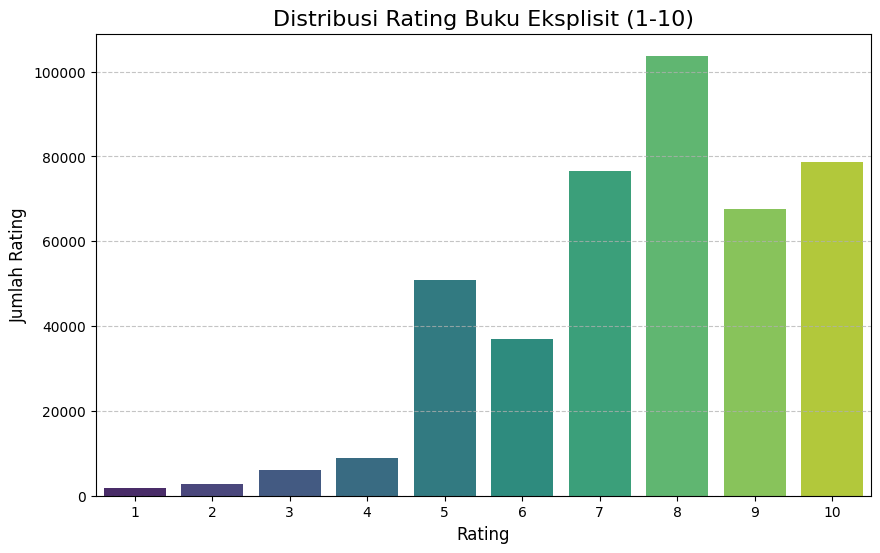

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=ratings_explicit, palette='viridis')
plt.title("Distribusi Rating Buku Eksplisit (1-10)", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Jumlah Rating", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75, linestyle='--')
plt.show()

Distribusi rating menunjukkan bahwa buku eksplisit umumnya diterima dengan sangat baik oleh pembaca. Rating yang dominan tinggi menunjukkan kepuasan yang tinggi, serta mungkin adanya komunitas pembaca yang loyal. Namun, penting juga mencermati kemungkinan bias dalam pemberian rating, seperti hanya pembaca yang menyukai genre tersebut yang meninggalkan ulasan.

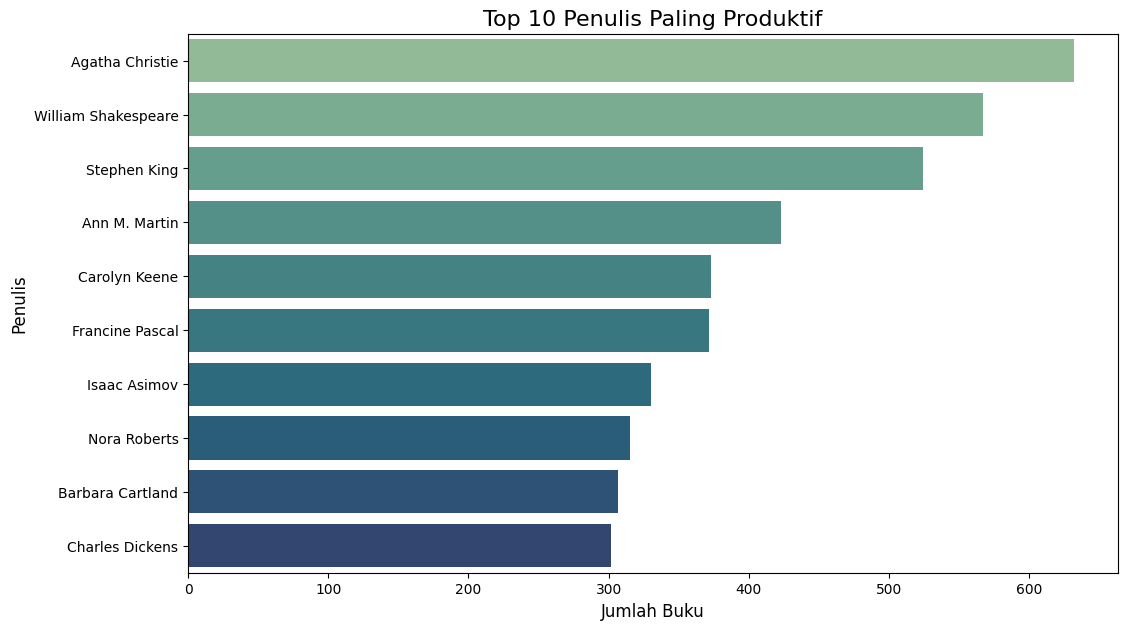

In [17]:
plt.figure(figsize=(12, 7))
top_authors = books['Book-Author'].value_counts().head(10)
sns.barplot(x=top_authors.values, y=top_authors.index, palette='crest')
plt.title("Top 10 Penulis Paling Produktif", fontsize=16)
plt.xlabel("Jumlah Buku", fontsize=12)
plt.ylabel("Penulis", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Agatha Christie memimpin sebagai penulis paling produktif, dengan Shakespeare dan King menyusul. Grafik ini menunjukkan bahwa produktivitas luar biasa bisa dicapai oleh penulis dari berbagai era dan genre, dan penulis serial cenderung memiliki volume karya lebih banyak. Informasi ini sangat bermanfaat untuk analisis pasar buku, tren genre, atau inspirasi bagi penulis baru.

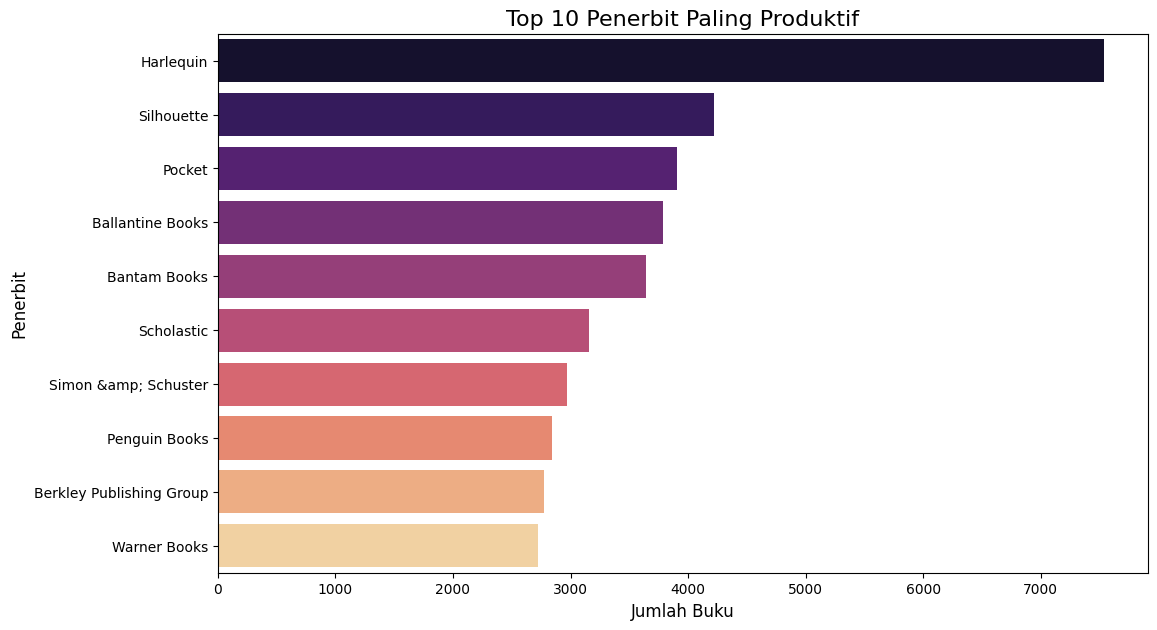

In [18]:
plt.figure(figsize=(12, 7))
top_publishers = books['Publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')
plt.title("Top 10 Penerbit Paling Produktif", fontsize=16)
plt.xlabel("Jumlah Buku", fontsize=12)
plt.ylabel("Penerbit", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Visualisasi ini menunjukkan bahwa Harlequin adalah penerbit paling produktif, secara signifikan mengungguli yang lain. Sementara itu, sembilan penerbit lainnya memiliki volume yang relatif serupa, menandakan kompetisi yang lebih merata di luar dominasi Harlequin.

In [19]:
sampled_books = books.dropna(subset=['Book-Title']).sample(n=40000, random_state=42).reset_index(drop=True)


Mengambil 40000 sample dari dataset books, karena terlalu banyak 271000 yang menyebabkan selalu crash saat menjalankan program (RAM tidak memenuhi untuk load dataset 271000)

In [20]:
sampled_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0679764275,The F Word,Jesse Sheidlower,1995,Random House Reference Publishing,http://images.amazon.com/images/P/0679764275.0...,http://images.amazon.com/images/P/0679764275.0...,http://images.amazon.com/images/P/0679764275.0...
1,3257228589,Davids Rache.,Hans Werner Kettenbach,1996,Diogenes Verlag,http://images.amazon.com/images/P/3257228589.0...,http://images.amazon.com/images/P/3257228589.0...,http://images.amazon.com/images/P/3257228589.0...
2,0812577647,Sky Knife,Marella Sands,2000,Tor Books,http://images.amazon.com/images/P/0812577647.0...,http://images.amazon.com/images/P/0812577647.0...,http://images.amazon.com/images/P/0812577647.0...
3,0156372118,The Groves of Academe,Mary McCarthy,1992,Harcourt,http://images.amazon.com/images/P/0156372118.0...,http://images.amazon.com/images/P/0156372118.0...,http://images.amazon.com/images/P/0156372118.0...
4,0590470485,Karen's Lucky Penny (Baby-Sitters Little Siste...,Ann M. Martin,1994,Scholastic,http://images.amazon.com/images/P/0590470485.0...,http://images.amazon.com/images/P/0590470485.0...,http://images.amazon.com/images/P/0590470485.0...


In [21]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(sampled_books['Book-Title'])

print("Ukuran TF-IDF Matrix:", tfidf_matrix.shape) 

Ukuran TF-IDF Matrix: (40000, 29535)


In [22]:
cosine_sim = cosine_similarity(tfidf_matrix)

metode TF-IDF untuk mengekstrak fitur teks dari judul buku dan cosine similarity untuk mengukur kesamaan antarjudul. Setelah membentuk matriks TF-IDF berukuran 40.000 × 29.535

In [23]:
title_to_index = pd.Series(sampled_books.index, index=sampled_books['Book-Title']).drop_duplicates()

In [24]:
def get_similar_books(title, top_n=5):
    try:
        if title not in title_to_index:
            return []
        
        idx = title_to_index[title]

        # Pastikan idx adalah integer
        if isinstance(idx, pd.Series):  # bisa terjadi jika ada duplikat index
            idx = idx.iloc[0]

        # Ambil vektor similarity dan pastikan hasilnya 1D
        sim_scores = cosine_sim[idx]  # 1D array (misal: shape (40000,))
        
        # Enumerate dan urutkan berdasarkan skor tertinggi (kecuali dirinya sendiri)
        sim_scores = list(enumerate(sim_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # skip dirinya sendiri (posisi 0)

        book_indices = [i[0] for i in sim_scores]
        return [sampled_books.iloc[i]['Book-Title'] for i in book_indices]

    except Exception as e:
        print(f"⚠️ Error saat merekomendasikan untuk judul: {title}")
        print(e)
        return []


fungsi get_similar_books() untuk merekomendasikan top-n buku yang paling mirip dengan judul yang diberikan

In [25]:
# 7. Evaluasi dengan Precision@5 dan Recall@5
ratings_books_filtered = merged_ratings_books[merged_ratings_books['Book-Title'].isin(sampled_books['Book-Title'])].copy()
user_likes = ratings_books_filtered[ratings_books_filtered['Book-Rating'] >= 8]  # dianggap relevan

# Top 100 pengguna paling aktif
top_users = user_likes['User-ID'].value_counts().head(100).index

precision_list = []
recall_list = []

for user in tqdm(top_users):
    liked_books = user_likes[user_likes['User-ID'] == user]['Book-Title'].unique()
    recommended = set()

    for book in liked_books:
        recommended.update(get_similar_books(book, top_n=5))

    recommended = list(recommended)
    relevant = set(liked_books)

    # Hitung true positives
    true_positives = len(set(recommended) & relevant)
    precision = true_positives / len(recommended) if recommended else 0
    recall = true_positives / len(relevant) if relevant else 0

    precision_list.append(precision)
    recall_list.append(recall)

# Rata-rata
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)

print(f"\n📊 Hasil Evaluasi:")
print(f"📌 Precision@5 (rata-rata): {avg_precision:.4f}")
print(f"📌 Recall@5 (rata-rata):    {avg_recall:.4f}")


100%|██████████| 100/100 [05:09<00:00,  3.09s/it]


📊 Hasil Evaluasi:
📌 Precision@5 (rata-rata): 0.0598
📌 Recall@5 (rata-rata):    0.2461


mengevaluasi akurasi sistem rekomendasi dengan menghitung rata-rata Precision@5 dan Recall@5 berdasarkan 100 pengguna paling aktif. Buku yang diberi rating ≥ 8 dianggap relevan, dan sistem menghitung seberapa banyak rekomendasi top-5 yang benar-benar sesuai dengan preferensi pengguna. Hasil evaluasi menunjukkan nilai Precision@5 sebesar 0.0598 dan Recall@5 sebesar 0.2461, yang mengindikasikan bahwa dari 5 rekomendasi, sekitar 6% akurat dan sistem mampu menangkap sekitar 25% dari buku-buku relevan yang pernah disukai pengguna.

# Contoh Penerapan Output

In [26]:
query = "Sky Knife"
print(f"\n📚 Rekomendasi untuk buku: '{query}'")
rekomendasi = get_similar_books(query, top_n=5)
for i, book in enumerate(rekomendasi, 1):
    print(f"{i}. {book}")


📚 Rekomendasi untuk buku: 'Sky Knife'
1. Under the Knife
2. Under the Knife
3. Be My Knife: A Novel
4. Three Uses of the Knife
5. Night Sky
